# Checkpoint 3 - Multi-Class Classification of Walmart Product Data

## Overview

Our group is exploring the feasibility to predict price ranges from written Walmart product descriptions. In this report, we discuss the performance of several classifier models and review the results of our tuning process for our core algorithim.

We explore the following models:

1. $k$-Nearest Neighbors (Core Algorithm)
1. Logistic Regression
1. Random Forest
1. Linear SVM

In [1]:
# Update the working directory to be the project root directory.
from pathlib import Path, PurePosixPath
PROJECT_DIR = Path.cwd().resolve().parents[0]
%cd {PROJECT_DIR}

D:\Repositories\rit\ISTE780\Project


In [2]:
# Display list of available pipeline tasks.
!doit list

clean_data        Clean the raw dataset (.csv) and place in the interim folder.
create_data_dir   Create the data directory.
create_env        Create new conda environment using 'environment.yaml'.
download_data     Download the dataset from Kaggle.
unpack_data       Unpack the raw dataset (.zip) as the (.csv) file.
update_env        Update existing conda environment using 'environment.yaml'.


## Data Review

The data used to fit our classifiers has received some preprocessing. Notably, we have removed features that were specific to Walmart operations (i.e., Walmart Lot and Item Numbers) and some erroneous features that were missing all or large amounts of data (i.e., the "Available" feature in the original dataset). We have also filtered out rows that were inappropriately listed as `$0.00 USD`.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
data_uri = "data/interim/ecommerce_data-cleaned-0.2.2.csv"
products_raw = pd.read_csv(data_uri, index_col=0)
products_raw.head()

,brand,name,description,category_raw,price_raw,discount_raw,price_range
0,La Costeï¿½ï¿½a,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)",We aim to show you accurate product informati...,"Food | Meal Solutions, Grains & Pasta | Canned...",31.93,31.93,"(30, 35]"
1,Equate,Equate Triamcinolone Acetonide Nasal Allergy S...,We aim to show you accurate product informati...,Health | Equate | Equate Allergy | Equate Sinu...,10.48,10.48,"(10, 20]"
2,AduroSmart ERIA,AduroSmart ERIA Soft White Smart A19 Light Bul...,We aim to show you accurate product informati...,Electronics | Smart Home | Smart Energy and Li...,10.99,10.99,"(10, 20]"
3,lowrider,"24"" Classic Adjustable Balloon Fender Set Chro...",We aim to show you accurate product informati...,Sports & Outdoors | Bikes | Bike Accessories |...,38.59,38.59,"(35, 40]"
4,Anself,Elephant Shape Silicone Drinkware Portable Sil...,We aim to show you accurate product informati...,Baby | Feeding | Sippy Cups: Alternatives to P...,5.81,5.81,"(0, 10]"


We would like to perform some preliminary preprocessing on the text fields, to ensure they place nicely with our classifiers.

In [5]:
# Download stopwords.
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\effen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Get the stopwords.
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import regex

# Setup function for cleaning text fields of stop words.
words = stopwords.words("english")
stemmer = PorterStemmer()
def clean_text(feature):
    return " ".join([stemmer.stem(i) for i in regex.sub("[^a-zA-Z0-9]", " ", feature).split() if i not in words]).lower()

In [25]:
# Clean the brand, name, and description fields.
products = products_raw.iloc[:2000,].copy()
products['name'] = products.name.fillna("").apply(clean_text)
products['brand'] = products.brand.fillna("").apply(clean_text)
products['description'] = products.description.fillna("").apply(clean_text)
products['category_raw'] = products.category_raw.fillna("")
display(products)

,brand,name,description,category_raw,price_raw,discount_raw,price_range
0,la cost,la costena chipotl pepper 7 oz pack 12,we aim show accur product inform manufactur su...,"Food | Meal Solutions, Grains & Pasta | Canned...",31.93,31.93,"(30, 35]"
1,equat,equat triamcinolon acetonid nasal allergi spra...,we aim show accur product inform manufactur su...,Health | Equate | Equate Allergy | Equate Sinu...,10.48,10.48,"(10, 20]"
2,adurosmart eria,adurosmart eria soft white smart a19 light bul...,we aim show accur product inform manufactur su...,Electronics | Smart Home | Smart Energy and Li...,10.99,10.99,"(10, 20]"
3,lowrid,24 classic adjust balloon fender set chrome bi...,we aim show accur product inform manufactur su...,Sports & Outdoors | Bikes | Bike Accessories |...,38.59,38.59,"(35, 40]"
4,anself,eleph shape silicon drinkwar portabl silicon c...,we aim show accur product inform manufactur su...,Baby | Feeding | Sippy Cups: Alternatives to P...,5.81,5.81,"(0, 10]"
...,...,...,...,...,...,...,...
2027,dr scholl,dr scholl clear away wart remov plantar 24 eac...,we aim show accur product inform manufactur su...,Health | Foot Care | Wart Removers,30.82,30.82,"(30, 35]"
2028,costa del mar,costa neon trucker black twill hat neon blue,we aim show accur product inform manufactur su...,Clothing | Bags & Accessories | Mens Bags & Ac...,50.85,50.85,"(50, 100]"
2029,the seawe bath co,the seawe bath co awaken rosemari mint firm de...,we aim show accur product inform manufactur su...,Personal Care | Bath & Body | Body Lotions & C...,13.61,13.61,"(10, 20]"
2030,wilson,wilson burn 100ul tenni racquet,we aim show accur product inform manufactur su...,Sports & Outdoors | Sports | Tennis & Racquets...,139.00,139.00,"(100, 100+]"


## Pipeline Setup

The following steps prepare the train test splits for the classifiers.

In [26]:
# Prepare the train/test splits.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split data into features and labels:
X = products.loc[:,'brand':'category_raw']

# Encode labels.
le = LabelEncoder()
le.fit(products.loc[:,'price_range'].unique())
y = le.transform(products.loc[:,'price_range'])

# Split into the train test splits.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
display(f"X train: {X_train.shape}")
display(f"y train: {y_train.shape}")
display(f"X test: {X_test.shape}")
display(f"y test: {y_test.shape}")
display(X,y)
# display(le.inverse_transform(y_test))

'X train: (1500, 4)'

'y train: (1500,)'

'X test: (500, 4)'

'y test: (500,)'

,brand,name,description,category_raw
0,la cost,la costena chipotl pepper 7 oz pack 12,we aim show accur product inform manufactur su...,"Food | Meal Solutions, Grains & Pasta | Canned..."
1,equat,equat triamcinolon acetonid nasal allergi spra...,we aim show accur product inform manufactur su...,Health | Equate | Equate Allergy | Equate Sinu...
2,adurosmart eria,adurosmart eria soft white smart a19 light bul...,we aim show accur product inform manufactur su...,Electronics | Smart Home | Smart Energy and Li...
3,lowrid,24 classic adjust balloon fender set chrome bi...,we aim show accur product inform manufactur su...,Sports & Outdoors | Bikes | Bike Accessories |...
4,anself,eleph shape silicon drinkwar portabl silicon c...,we aim show accur product inform manufactur su...,Baby | Feeding | Sippy Cups: Alternatives to P...
...,...,...,...,...
2027,dr scholl,dr scholl clear away wart remov plantar 24 eac...,we aim show accur product inform manufactur su...,Health | Foot Care | Wart Removers
2028,costa del mar,costa neon trucker black twill hat neon blue,we aim show accur product inform manufactur su...,Clothing | Bags & Accessories | Mens Bags & Ac...
2029,the seawe bath co,the seawe bath co awaken rosemari mint firm de...,we aim show accur product inform manufactur su...,Personal Care | Bath & Body | Body Lotions & C...
2030,wilson,wilson burn 100ul tenni racquet,we aim show accur product inform manufactur su...,Sports & Outdoors | Sports | Tennis & Racquets...


array([5, 1, 1, ..., 1, 2, 0])

In [27]:
# Prepare the pipeline.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", sublinear_tf=True, norm='l2')
column_transformer = ColumnTransformer([('name', vectorizer, 'name'),
                                        ('description', vectorizer, 'description'),
                                        ('brand', vectorizer, 'brand'),
                                        ('category_raw', vectorizer, 'category_raw'),
                                       ], remainder='drop', verbose_feature_names_out=False)

In [34]:
# Metric calculation function:
from sklearn.metrics import classification_report, confusion_matrix
def show_metrics(clf, test_X, test_y):
    print(f'Classification score: {clf.score(test_X, test_y) * 100}%')
    print(classification_report(np.array(test_y), clf.predict(test_X), zero_division=0))
    print(confusion_matrix(np.array(test_y), clf.predict(test_X)))

## Baseline Classifier

In order to compare our models to a reasonable baseline, we fit the model features using a `DummyClassifier` that makes predictions using simple rules.

In [28]:
# Import the DummyClassifier
from sklearn.dummy import DummyClassifier

# Create the DummyClassifier pipeline.
clf_dummy = Pipeline([('vect', column_transformer),
                      ('chi', SelectKBest(chi2, k=50)),
                      ('clf', DummyClassifier(strategy='stratified'))])

# Fit the dummy classifier.
clf_dummy.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 ColumnTransformer(transformers=[('name',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'name'),
                                                 ('description',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'description'),
                                                 ('brand',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'brand'),
                                                 ('category_raw',
                    

In [35]:
show_metrics(clf_dummy, X_test, y_test)

Classification score: 15.0%
              precision    recall  f1-score   support

           0       0.26      0.25      0.26       110
           1       0.22      0.22      0.22       123
           2       0.10      0.14      0.12        50
           3       0.06      0.06      0.06        47
           4       0.04      0.03      0.03        36
           5       0.04      0.04      0.04        25
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        17
           8       0.10      0.06      0.08        16
           9       0.08      0.08      0.08        59

    accuracy                           0.15       500
   macro avg       0.09      0.09      0.09       500
weighted avg       0.14      0.15      0.14       500

[[25 27 12 12  2 11  4  4  2 11]
 [32 34 17  6  6 13  5  1  3  6]
 [ 7 15  9  3  2  1  4  1  1  7]
 [10 13  8  4  1  3  0  1  0  7]
 [ 7  8  4  5  3  2  0  1  1  5]
 [ 4  4  4  1  3  2  2  1  0  4]
 [ 4  4  2  1  

## $k$-Nearest Neighbor Classifier

Overview: <What does this classifier do? How does it work?>

### Baseline $k$-Nearest Neighbor Summary

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Create the baseline kNN pipeline
clf_kNN = Pipeline([('vect', column_transformer),
                      ('chi',  SelectKBest(chi2, k=1200)),
                      ('clf', KNeighborsClassifier())])

In [31]:
# Fit the kNN classifier.
clf_kNN.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 ColumnTransformer(transformers=[('name',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'name'),
                                                 ('description',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'description'),
                                                 ('brand',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'brand'),
                                                 ('category_raw',
                    

In [36]:
show_metrics(clf_kNN, X_test, y_test)

Classification score: 26.6%
              precision    recall  f1-score   support

           0       0.29      0.70      0.41       110
           1       0.23      0.33      0.27       123
           2       0.35      0.26      0.30        50
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        16
           9       0.20      0.05      0.08        59

    accuracy                           0.27       500
   macro avg       0.11      0.13      0.11       500
weighted avg       0.18      0.27      0.20       500

[[77 29  3  0  0  0  0  0  0  1]
 [71 40  6  3  0  0  0  0  0  3]
 [13 20 13  2  0  0  0  0  0  2]
 [23 20  3  0  0  0  0  0  0  1]
 [18 12  1  1  0  0  1  0  0  3]
 [12  9  3  1  0  0  0  0  0  0]
 [ 9  6  0  1  

### Tuning the $k$-Nearest Neighbor Classifier

In [61]:
%%time
# Using the elbow method to find optimal K.
error_rate = []

tuple_range =range(5,12)
# Will take some time
for i in tuple_range:
    elb_KNN = Pipeline([('vect', column_transformer),
                      ('chi',  SelectKBest(chi2, k=1200)),
                      ('clf', KNeighborsClassifier(n_neighbors=i))])
    elb_KNN.fit(X_train, y_train)
    y_i = elb_KNN.predict(X_test)
    error_rate.append(np.mean(y_i != y_test))

Wall time: 2.89 s


Text(0, 0.5, 'Error Rate')

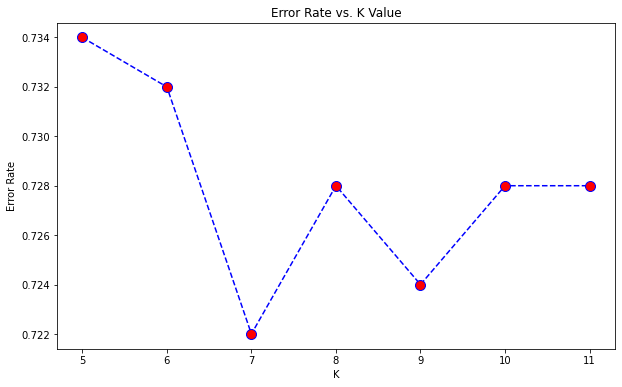

In [62]:
plt.figure(figsize=(10,6))
plt.plot(tuple_range,error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [75]:
import seaborn as sns

f = plt.figure(figsize=(20,4))
f.add_subplot(1,2,1)
sns.distplot(y_train)
f.add_subplot(1,2,2)
sns.boxplot(y_train)

ModuleNotFoundError: No module named 'seaborn'

In [72]:
from sklearn.model_selection import GridSearchCV

# Setup GridSearchCV for our model.
parameters = {'n_neighbors':range(5,10)}
knn = KNeighborsClassifier()
cv_KNN = GridSearchCV(knn, parameters)

# Create the baseline kNN pipeline
clf_kNN2 = Pipeline([('vect', column_transformer),
                      ('chi',  SelectKBest(chi2, k=1200)),
                      ('clf', cv_KNN)])

In [73]:
# Fit the kNN classifier.
clf_kNN2.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 ColumnTransformer(transformers=[('name',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'name'),
                                                 ('description',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'description'),
                                                 ('brand',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'brand'),
                                                 ('category_raw',
                    

In [74]:
show_metrics(clf_kNN2, X_test, y_test)

Classification score: 27.800000000000004%
              precision    recall  f1-score   support

           0       0.29      0.65      0.40       110
           1       0.25      0.42      0.32       123
           2       0.39      0.24      0.30        50
           3       0.14      0.02      0.04        47
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        16
           9       0.27      0.05      0.09        59

    accuracy                           0.28       500
   macro avg       0.13      0.14      0.11       500
weighted avg       0.21      0.28      0.21       500

[[71 36  3  0  0  0  0  0  0  0]
 [63 52  5  2  0  0  0  0  0  1]
 [12 21 12  2  0  0  0  0  0  3]
 [19 24  3  1  0  0  0  0  0  0]
 [16 17  1  1  0  0  0  0  0  1]
 [12 10  3  0  0  0  0  0  0  0]
 

## Logistic Regression

Overview: <What does this classifier do? How does it work?>

In [38]:
from sklearn.linear_model import LogisticRegression

# Create the LogisticRegression pipeline.
clf_logreg = Pipeline([('vect', column_transformer),
                      ('chi', SelectKBest(chi2, k=50)),
                      ('clf', LogisticRegression(multi_class='multinomial', max_iter=1000))])

In [39]:
# Fit the logistic regression classifier.
clf_logreg.fit(X_train, y_train)
show_metrics(clf_logreg, X_test, y_test)

Classification score: 25.0%
              precision    recall  f1-score   support

           0       0.33      0.02      0.03       110
           1       0.25      0.98      0.40       123
           2       0.67      0.04      0.08        50
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        59

    accuracy                           0.25       500
   macro avg       0.12      0.10      0.05       500
weighted avg       0.20      0.25      0.11       500

[[  2 108   0   0   0   0   0   0   0   0]
 [  2 121   0   0   0   0   0   0   0   0]
 [  0  47   2   0   0   1   0   0   0   0]
 [  0  45   0   0   0   0   0   0   0   2]
 [  1  34   1   0   0   0   0   0   0   0

## Random Forest

Overview: <What does this classifier do? How does it work?>

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Create the RandomForestClassifier pipeline.
clf_RF = Pipeline([('vect', column_transformer),
                   ('chi', SelectKBest(chi2, k=7000)),
                   ('clf', RandomForestClassifier())])

In [42]:
# Fit the random forest classifier.
clf_RF.fit(X_train, y_train)
show_metrics(clf_RF, X_test, y_test)

Classification score: 24.8%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.25      0.98      0.40       123
           2       0.33      0.02      0.04        50
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        25
           6       0.33      0.06      0.10        17
           7       0.20      0.06      0.09        17
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        59

    accuracy                           0.25       500
   macro avg       0.11      0.11      0.06       500
weighted avg       0.11      0.25      0.11       500

[[  0 107   1   0   0   0   0   2   0   0]
 [  0 121   1   0   0   0   0   1   0   0]
 [  0  47   1   0   0   1   0   0   1   0]
 [  0  43   0   0   0   0   1   1   0   2]
 [  0  34   0   0   0   0   1   0   1   0

## RBF (Radial Basis Function) SVM

Overview: <What does this classifier do? How does it work?>

In [48]:
from sklearn.svm import SVC

# Create the RandomForestClassifier pipeline.
clf_SVM = Pipeline([('vect', column_transformer),
                   ('chi',  SelectKBest(chi2, k=7000)),
                   ('clf', SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo'))])

In [47]:
# Fit the random forest classifier.
clf_SVM.fit(X_train, y_train)
show_metrics(clf_SVM, X_test, y_test)

Classification score: 29.2%
              precision    recall  f1-score   support

           0       0.34      0.29      0.31       110
           1       0.27      0.80      0.40       123
           2       0.46      0.24      0.32        50
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        16
           9       0.60      0.05      0.09        59

    accuracy                           0.29       500
   macro avg       0.17      0.14      0.11       500
weighted avg       0.26      0.29      0.21       500

[[32 73  3  1  0  0  0  0  0  1]
 [23 99  1  0  0  0  0  0  0  0]
 [ 1 37 12  0  0  0  0  0  0  0]
 [ 7 38  1  0  1  0  0  0  0  0]
 [ 7 27  1  0  0  1  0  0  0  0]
 [ 5 18  1  0  0  0  0  0  0  1]
 [ 4 11  2  0  